In [7]:
!pip install kaggle



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import os

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
os.replace("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

print("Kaggle API key set successfully!")


Kaggle API key set successfully!


In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rohanrao/air-quality-data-in-india")

print("Path to dataset files:", path)

Resuming download from 32505856 bytes (43963723 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/rohanrao/air-quality-data-in-india?dataset_version_number=12 (32505856/76469579) bytes left.


100%|█████████████████████████████████████████████████████████████████████████████| 72.9M/72.9M [00:05<00:00, 7.82MB/s]

Extracting files...


Path to dataset files: C:\Users\91822\.cache\kagglehub\datasets\rohanrao\air-quality-data-in-india\versions\12


In [10]:
import os
files=os.listdir(path)
print(files)

['city_day.csv', 'city_hour.csv', 'stations.csv', 'station_day.csv', 'station_hour.csv']


In [12]:
!pip install plotly


   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.9 MB 5.7 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.9 MB 6.3 MB/s eta 0:00:02
   ------------- -------------------------- 3.4/9.9 MB 6.9 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.9 MB 7.2 MB/s eta 0:00:01
   ---------------------------- ----------- 7.1/9.9 MB 7.7 MB/s eta 0:00:01
   ------------------------------------ --- 8.9/9.9 MB 8.1 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 7.7 MB/s  0:00:01



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
warnings.filterwarnings("ignore")

In [14]:
#!pip install pmdarima
#import pmdarima as pm

In [16]:
!pip install statsmodels
!pip install prophet


   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.5 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.5 MB 3.1 MB/s eta 0:00:03
   ------- -------------------------------- 1.8/9.5 MB 3.6 MB/s eta 0:00:03
   ------------ --------------------------- 2.9/9.5 MB 4.0 MB/s eta 0:00:02
   ---------------- ----------------------- 3.9/9.5 MB 4.3 MB/s eta 0:00:02
   --------------------- ------------------ 5.2/9.5 MB 4.6 MB/s eta 0:00:01
   --------------------------- ------------ 6.6/9.5 MB 4.9 MB/s eta 0:00:01
   ---------------------------------- ----- 8.1/9.5 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 5.4 MB/s  0:00:01

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -----------------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
    --------------------------------------- 0.3/12.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.6/12.1 MB 6.5 MB/s eta 0:00:02
   ---------- ----------------------------- 3.1/12.1 MB 7.1 MB/s eta 0:00:02
   ---------------- ----------------------- 5.0/12.1 MB 7.4 MB/s eta 0:00:01
   --------------------- ------------------ 6.6/12.1 MB 7.6 MB/s eta 0:00:01
   ---------------------------- ----------- 8.7/12.1 MB 8.0 MB/s eta 0:00:01
   ---------------------------------- ----- 10.5/12.1 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------  12.1/12.1 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 12.1/12.1 MB 7.8 MB/s  0:00:01
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 7.7 MB/s  0:00:00

   -------- ------------------------------- 1/5 [importlib_resources]
   -------- -------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Forecasting tools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

In [18]:
stations = pd.read_csv(os.path.join(path, "stations.csv"))
station_hour = pd.read_csv(os.path.join(path, "station_hour.csv"))
station_day = pd.read_csv(os.path.join(path, "station_day.csv"))
city_hour = pd.read_csv(os.path.join(path, "city_hour.csv"))
city_day = pd.read_csv(os.path.join(path, "city_day.csv"))

for name, df in zip(
    ["stations","station_hour","station_day","city_hour","city_day"],
    [stations,station_hour,station_day,city_hour,city_day]):
    print(f"{name:15s} → {df.shape}")

stations        → (230, 5)
station_hour    → (2589083, 16)
station_day     → (108035, 16)
city_hour       → (707875, 16)
city_day        → (29531, 16)


In [19]:
def preprocess_city_day(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    df['City'] = df['City'].astype(str).str.strip()

    # Convert pollutant columns to numeric
    for col in df.columns:
        if col not in ['City', 'Date']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort & forward-fill within each city
    df = df.sort_values(['City', 'Date'])
    df = (
        df.groupby('City', group_keys=False)
          .apply(lambda g: g.set_index('Date').asfreq('D').fillna(method='ffill'))
          .reset_index()
    )
    return df

city_day_clean = preprocess_city_day(city_day)
city_day_clean.head()

,Date,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,2015-01-01,Ahmedabad,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,2015-01-02,Ahmedabad,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,2015-01-03,Ahmedabad,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,2015-01-04,Ahmedabad,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,2015-01-05,Ahmedabad,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


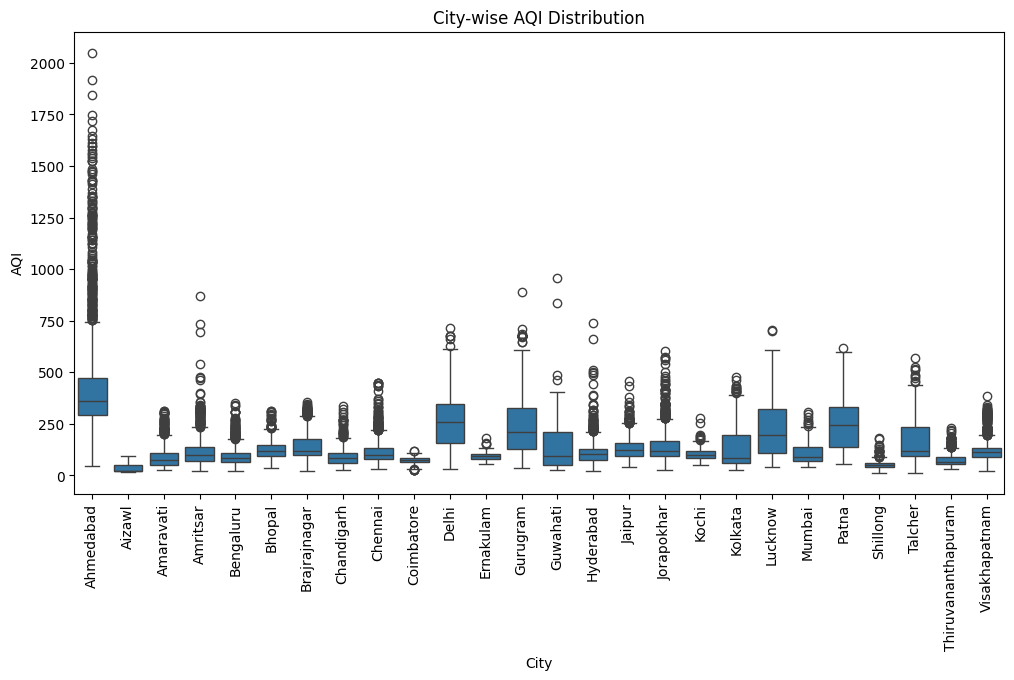

Top polluted cities (by average AQI):
City
Ahmedabad       423.472993
Delhi           258.632653
Patna           241.798731
Gurugram        231.266954
Lucknow         216.543523
Talcher         165.016000
Brajrajnagar    145.709712
Jorapokhar      143.452911
Guwahati        139.504990
Kolkata         135.372694
Name: AQI, dtype: float64


In [20]:
plt.figure(figsize=(12,6))
sns.boxplot(x='City', y='AQI', data=city_day_clean)
plt.xticks(rotation=90)
plt.title("City-wise AQI Distribution")
plt.show()

print("Top polluted cities (by average AQI):")
print(city_day_clean.groupby("City")["AQI"].mean().sort_values(ascending=False).head(10))

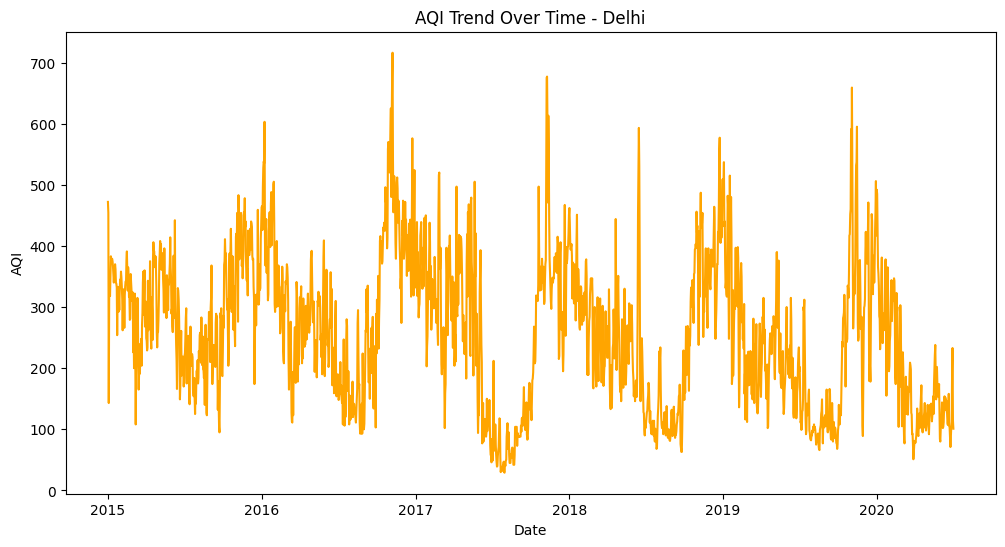

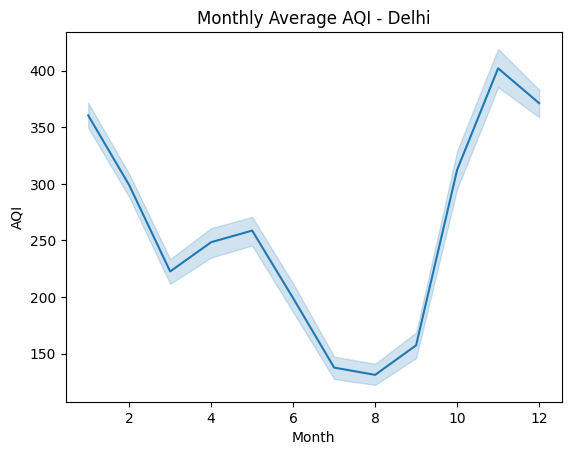

In [21]:
city = "Delhi"  # change to any other city from your dataset
city_df = city_day_clean[city_day_clean["City"] == city].sort_values("Date")

plt.figure(figsize=(12,6))
plt.plot(city_df["Date"], city_df["AQI"], color="orange")
plt.title(f"AQI Trend Over Time - {city}")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.show()

city_df["Month"] = city_df["Date"].dt.month
sns.lineplot(x="Month", y="AQI", data=city_df)
plt.title(f"Monthly Average AQI - {city}")
plt.show()

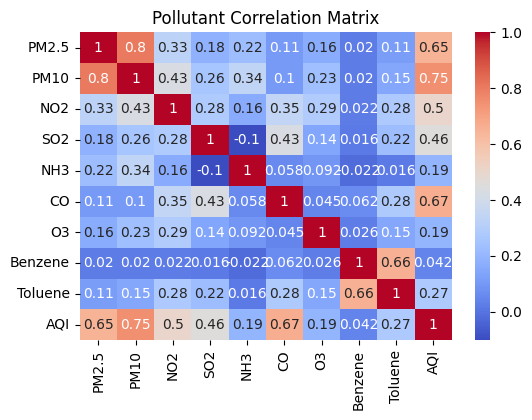

In [ ]:
pollutants = ['PM2.5','PM10','NO2','SO2','NH3','CO','O3','Benzene','Toluene']
poll_cols = [c for c in pollutants if c in city_day_clean.columns]
corr = city_day_clean[poll_cols + ['AQI']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Pollutant Correlation Matrix")
plt.show()

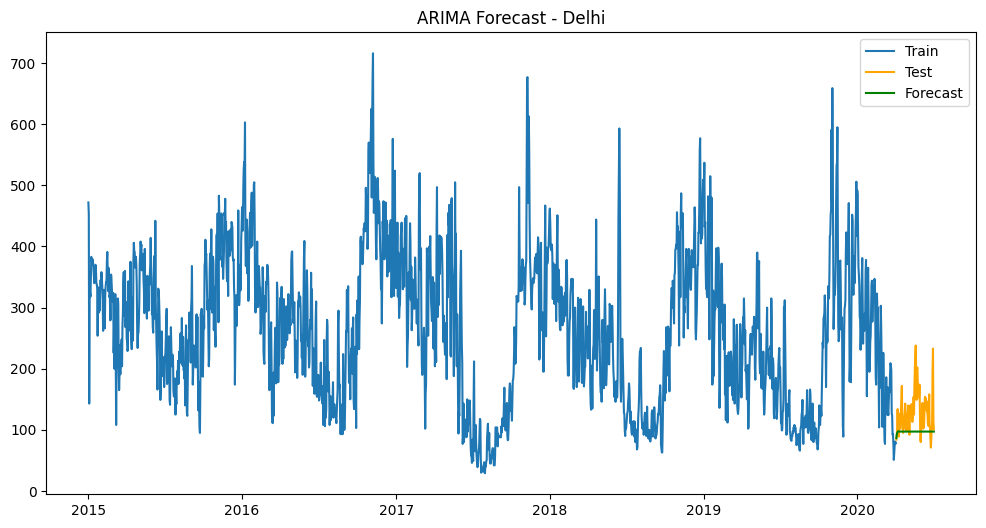

In [22]:
series = city_df[["Date","AQI"]].set_index("Date").asfreq("D").fillna(method="ffill")
train, test = series.iloc[:-90], series.iloc[-90:]

# Choose (p,d,q) — start with (5,1,2), tweak if needed
model = ARIMA(train, order=(5,1,2))
fit = model.fit()

forecast = fit.forecast(steps=90)

plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.plot(forecast.index, forecast.values, label="Forecast", color="green")
plt.legend()
plt.title(f"ARIMA Forecast - {city}")
plt.show()
# mae = mean_absolute_error(test, forecast)
# rmse = mean_squared_error(test, forecast, squared=False)
# print("ARIMA MAE:", round(mae, 2))
# print("ARIMA RMSE:", round(rmse, 2))

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("ARIMA MAE:", round(mae, 2))
print("ARIMA RMSE:", round(rmse, 2))

ARIMA MAE: 35.5
ARIMA RMSE: 47.46


15:10:30 - cmdstanpy - INFO - Chain [1] start processing
15:10:31 - cmdstanpy - INFO - Chain [1] done processing


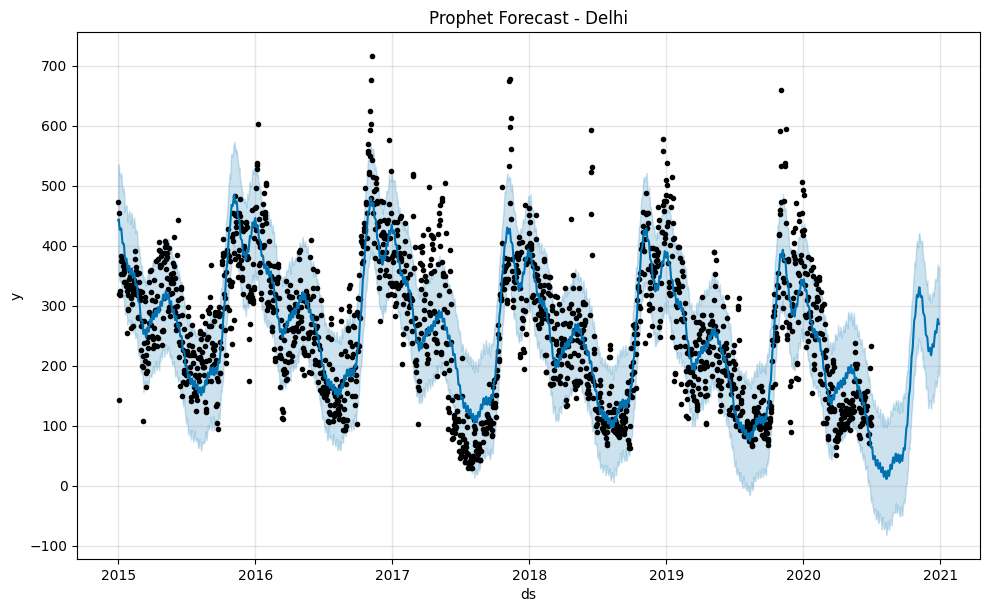

In [24]:
prophet_df = city_df[["Date","AQI"]].rename(columns={"Date":"ds","AQI":"y"})
m = Prophet()
m.fit(prophet_df)

future = m.make_future_dataframe(periods=180)
forecast = m.predict(future)

m.plot(forecast)
plt.title(f"Prophet Forecast - {city}")
plt.show()

# Evaluate Prophet
actual = prophet_df.set_index("ds")["y"].iloc[-90:]
pred = forecast.set_index("ds")["yhat"].iloc[-90:]
# mae_p = mean_absolute_error(actual, pred)
# rmse_p = mean_squared_error(actual, pred, squared=False)
# print("Prophet MAE:", round(mae_p, 2))
# print("Prophet RMSE:", round(rmse_p, 2))

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_p = mean_absolute_error(actual, pred)
rmse_p = np.sqrt(mean_squared_error(actual, pred))

print("Prophet MAE:", round(mae_p, 2))
print("Prophet RMSE:", round(rmse_p, 2))

Prophet MAE: 114.52
Prophet RMSE: 128.16


In [26]:
# High-risk cities
hr = city_day_clean.groupby("City")["AQI"].mean().sort_values(ascending=False)
print("Top 10 High-Risk Cities:\n", hr.head(10))

# Peak months across all cities
city_day_clean["Month"] = city_day_clean["Date"].dt.month
print("\nPeak Pollution Months:")
print(city_day_clean.groupby("Month")["AQI"].mean().sort_values(ascending=False))

# Policy recommendations
recommendations = [
    "🚗 Promote EVs and enforce stricter vehicle emission standards.",
    "🏭 Tighten industrial emission limits in high-risk cities.",
    "🎆 Regulate fireworks during festivals to curb spikes in AQI.",
    "🌳 Develop green buffer zones near pollution hotspots.",
    "🚸 Provide health advisories for vulnerable groups during high-AQI days."
]
print("\nPolicy Recommendations:")
for r in recommendations: print("-", r)

Top 10 High-Risk Cities:
 City
Ahmedabad       423.472993
Delhi           258.632653
Patna           241.798731
Gurugram        231.266954
Lucknow         216.543523
Talcher         165.016000
Brajrajnagar    145.709712
Jorapokhar      143.452911
Guwahati        139.504990
Kolkata         135.372694
Name: AQI, dtype: float64

Peak Pollution Months:
Month
11    238.909307
1     234.140113
12    225.844494
2     209.336482
10    181.734317
3     173.576847
4     147.892248
5     141.693975
6     126.114307
7     119.873185
9     118.639688
8     117.414146
Name: AQI, dtype: float64

Policy Recommendations:
- 🚗 Promote EVs and enforce stricter vehicle emission standards.
- 🏭 Tighten industrial emission limits in high-risk cities.
- 🎆 Regulate fireworks during festivals to curb spikes in AQI.
- 🌳 Develop green buffer zones near pollution hotspots.
- 🚸 Provide health advisories for vulnerable groups during high-AQI days.
